In [23]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.io import loadmat
import seaborn as sns
import re
from collections import Counter
from tqdm import trange, tqdm
from scipy.stats import dirichlet
sns.set()
plt.rcParams['figure.figsize'] = (16.0, 6.0)
%config InlineBackend.figure_format = 'retina'

In [2]:
vocab = set()
docs = []
 
D = 472 # number of documents
K = 10 # number of topics
 
# open each file; convert everything to lowercase and strip non-letter symbols; split into words
for fileind in range( 1, D+1 ):
    foo = open( 'data/output%04d.txt' % fileind ).read()    
    tmp = re.sub( '[^a-z ]+', ' ', foo.lower() ).split()
    docs.append( tmp )
 
    for w in tmp:
        vocab.add( w )

In [3]:
# vocab now has unique words
# give each word in the vocab a unique id
ind = 0
vhash = {}
vindhash = {}
for i in list(vocab):
    vhash[i] = ind
    vindhash[ind] = i
    ind += 1

# size of our vocabulary
V = ind

In [4]:
# reprocess each document and re-represent it as a list of word ids 
docs_i = []
for d in docs:
    dinds = []
    for w in d:
        dinds.append( vhash[w] )
    docs_i.append( dinds )

### Part 1: Gibbs Sampler

In [5]:
def randomly_assign_topics(docs, K):
    qs = []
    for doc in docs:
        q_i = np.random.randint(0, K, len(doc))
        qs.append(q_i)
    return qs

In [6]:
def calc_civk(qs):
    civk = np.zeros((D, V, K))
    for i in range(D):
        for k in range(K):
            topic_inds = np.where(qs[i] == k)
            topic_words = np.array(docs_i[i])[topic_inds]
            topic_word_counts = dict(Counter(topic_words))
            for w in topic_word_counts.keys():
                civk[i, w, k] = topic_word_counts[w]
    return civk

In [7]:
def compute_data_likelihood(docs_i, qs, bs, pis):
    p_sum = 0.    
    for i in range(len(docs_i)):
        for w in range(len(docs_i[i])):
            p_sum += np.log(bs[docs_i[i][w], qs[i][w]])
        p_sum += dirichlet.logpdf(pis[:,i], alphas)
    p_sum += np.sum(np.log(pis))   
    for k in range(K):
        p_sum += dirichlet.logpdf(bs[:,k], gammas)
    return p_sum

In [9]:
qs = randomly_assign_topics(docs_i, K)

# civk = calc_civk(qs)
 
alphas = np.ones((K, 1))[:,0]
gammas = np.ones((V, 1))[:,0]
 
# topic distributions
# bs = np.zeros((V, K))
bs = np.random.uniform(0., 1., (V, K))
bs /= np.sum(bs, axis=0)
# how should this be initialized?

# per-document-topic distributions
# pis = np.zeros((K, D))
pis = np.random.uniform(0., 1., (K, D))
pis /= np.sum(pis, axis=0)
# how should this be initialized?

In [ ]:
posts = []
for iters in range(100):
    civk = calc_civk(qs)
    p = compute_data_likelihood(docs_i, qs, bs, pis)
    posts.append(p)
    print("Iter %d, p=%.2f" % (iters, p))
 
    # resample per-word topic assignments bs
    cvk = civk.sum(axis=0)
    for k in range(K):
        bs[:,k] = np.random.dirichlet(cvk[:,k] + gammas)
 
    # resample per-document topic mixtures pis
    cik = civk.sum(axis=1)
    for i in range(D):
        pis[:,i] = np.random.dirichlet(cik[i] + alphas)
        
    # resample topics
    for i in range(len(docs_i)):
        for l in range(len(docs_i[i])):
            k_dist = pis[:,i] * bs[docs_i[i][l]]
            k_dist = k_dist / np.sum(k_dist)
#             q_il = list(range(K))[np.argmax(k_dist)]
            q_il = np.random.choice(K, p=k_dist)
            qs[i][l] = q_il
    plt.plot(posts)
    plt.show()

### Part 2: Collapsed Gibbs Sampler

In [8]:
def compute_data_likelihood_collapsed(docs_i, qs, civk):
    #estimate pis and bs
    ck = civk.sum(axis=0).sum(axis=0)
    pis = ck / ck.sum()
    cvk = civk.sum(axis=0) + 0.000001
    bs = cvk / cvk.sum(axis=0)
    
    p_sum = 0.
    for i in range(len(docs_i)):
        for w in range(len(docs_i[i])):
            p_sum += np.log(bs[docs_i[i][w], qs[i][w]])
        p_sum += dirichlet.logpdf(pis, alphas)
    p_sum += np.sum(np.log(pis))   
    for k in range(K):
        p_sum += dirichlet.logpdf(bs[:,k], gammas)
    return p_sum

In [11]:
qs = randomly_assign_topics(docs_i, K)

In [ ]:
posts_collapsed = []
for iters in range(100):
    civk = calc_civk(qs)
    p = compute_data_likelihood_collapsed(docs_i, qs, civk)
    posts_collapsed.append(p)
    print("Iter %d, p=%.2f" % (iters, p))
    
    cvk = civk.sum(axis=0)
    ck = cvk.sum(axis=0)
    cik = civk.sum(axis=1)
    L = cik.sum(axis=1)
    
    # resample topics
    for i in range(len(docs_i)):
        for l in range(len(docs_i[i])):
            p1 = (cvk[docs_i[i][l]] + 1) / (ck + V)
            p2 = (cik[i] + 1) / (L[i] + K)
            prob = p1 * p2
            prob /= np.sum(prob)
            q_il = np.random.choice(K, p=prob)
            qs[i][l] = q_il

### Plots & Visualizations

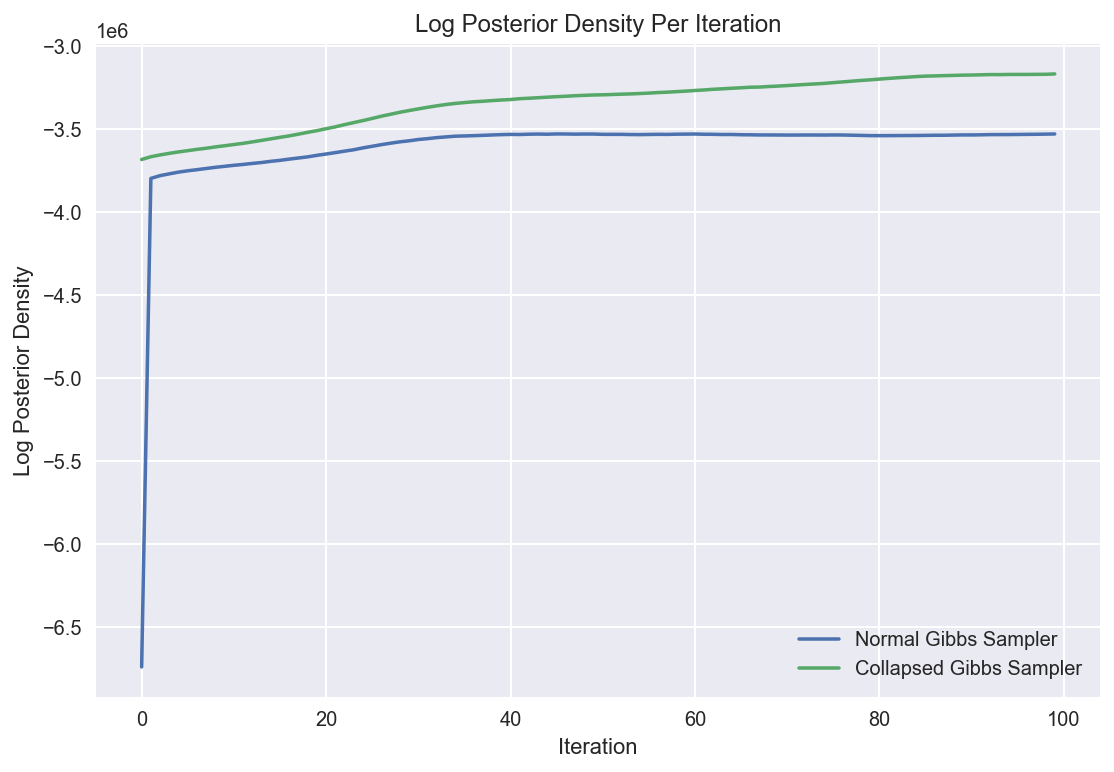

In [62]:
plt.rcParams['figure.figsize'] = (9.0, 6.0)
plt.plot(posts, label='Normal Gibbs Sampler')
plt.plot(posts_collapsed, label='Collapsed Gibbs Sampler')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Log Posterior Density')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Log Posterior Density Per Iteration')
plt.show()

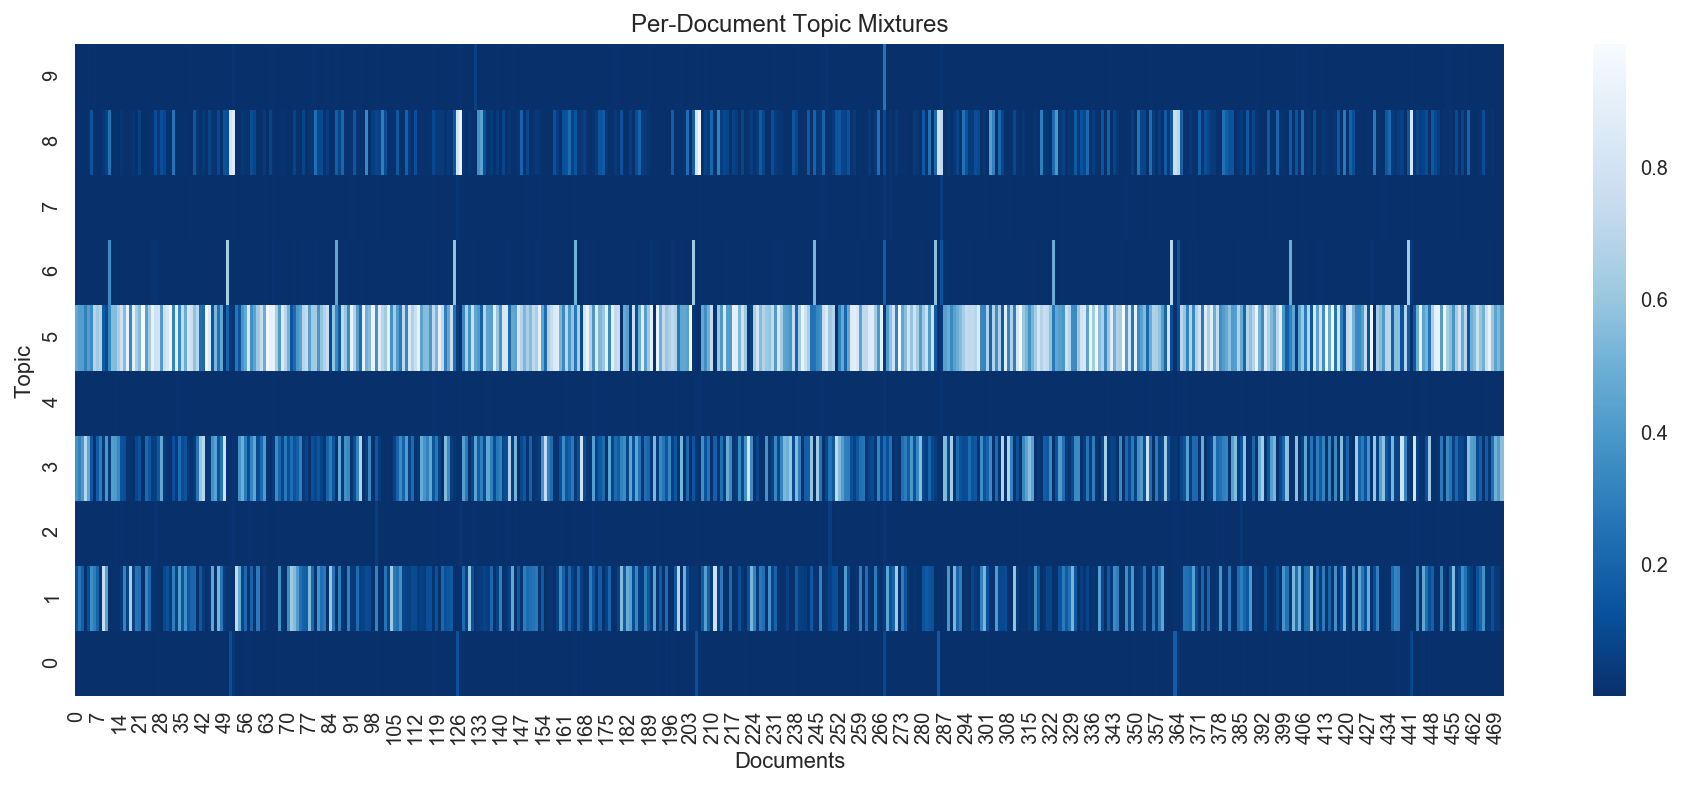

In [32]:
sns.heatmap(pis, cmap='Blues_r').invert_yaxis()
plt.ylabel("Topic")
plt.xlabel("Documents")
plt.title('Per-Document Topic Mixtures')
plt.show()

In [89]:
cvk = civk.sum(axis=0)
topics = cvk / cvk.sum(axis=0)
for k in range(K):
    words = topics[:,k].argsort()[-10:][::-1]
    probs = topics[words, k]
    print('GS Topic', k)
    for w, p in zip(words, probs):
        print('\t{:>12}\t{:0.6f}'.format(vindhash[w], p))

GS Topic 0
	 electricity	0.004920
	      turkey	0.003690
	     turnips	0.003690
	       parts	0.002460
	distractions	0.002460
	      entire	0.002460
	        lane	0.002460
	foundational	0.002460
	    likewise	0.002460
	       choir	0.002460
GS Topic 1
	         the	0.065995
	         and	0.040219
	          of	0.038479
	          to	0.035784
	          in	0.021437
	           a	0.017217
	        that	0.016602
	          we	0.014851
	           i	0.013831
	          is	0.011774
GS Topic 2
	       cents	0.003812
	    majority	0.002541
	    designer	0.002541
	     thanked	0.002541
	   synagogue	0.002541
	      nicole	0.002541
	     sorrows	0.002541
	   believing	0.002541
	     ensures	0.002541
	  prioritize	0.002541
GS Topic 3
	      calves	0.012687
	        eric	0.008074
	      corral	0.006920
	        cows	0.004614
	     pearson	0.004614
	     balloon	0.003460
	         hot	0.003460
	       dusty	0.003460
	       paddy	0.003460
	  repeatedly	0.002307
GS Topic 4
	         eva	0.018821
	 